In [ ]:
#Importing the all Libraries
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import models
from sklearn.preprocessing import label_binarize
import torch.optim as optim
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

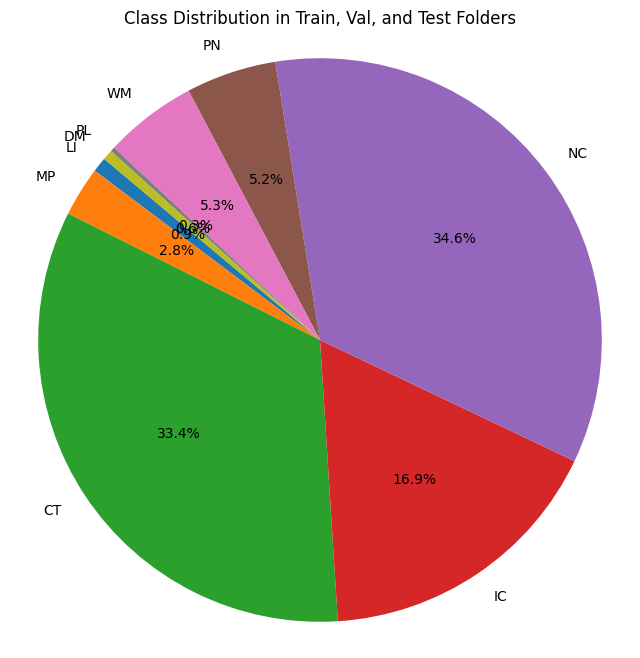


Class Information:
Total training images: 524476
Total validation images: 112378
Total test images: 112408
Total images in all splits: 749262

Total images per class (across all splits):
CT: 250370 images
DM: 4358 images
IC: 126772 images
LI: 6418 images
MP: 21348 images
NC: 259328 images
PL: 1998 images
PN: 38820 images
WM: 39850 images


In [ ]:
#The BraTS Path 2025 Dataset

# Where the datset is stored
train_dir = 'brats-path-2025/train'
val_dir = 'brats-path-2025/val'
test_dir = 'brats-path-2025/test'

# Counter for each cell type
train_counts = {}
val_counts = {}
test_counts = {}

# Total number of images in each section
total_train_images = 0
total_val_images = 0
total_test_images = 0

# Function to count images in the folders
def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len([f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))])
    return count

# Counting the total images
def count_split_images(base_dir, counter_dict):
    total = 0
    if not os.path.exists(base_dir):
        return 0
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            count = count_images(class_path)
            counter_dict[class_name] = count
            total += count
    return total

# Grouping the numbers together
total_train_images = count_split_images(train_dir, train_counts)
total_val_images = count_split_images(val_dir, val_counts)
total_test_images = count_split_images(test_dir, test_counts)

# Organising the numbers for the pie chart
all_class_names = set(train_counts) | set(val_counts) | set(test_counts)
total_images_per_class = {
    cls: train_counts.get(cls, 0) + val_counts.get(cls, 0) + test_counts.get(cls, 0)
    for cls in all_class_names
}

# Organising
class_names = list(total_images_per_class.keys())
class_distributions = list(total_images_per_class.values())

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(class_distributions, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in Train, Val, and Test Folders')
plt.axis('equal')
plt.show()

# Printing out my results
print("\nClass Information:")
print(f"Total training images: {total_train_images}")
print(f"Total validation images: {total_val_images}")
print(f"Total test images: {total_test_images}")
print(f"Total images in all splits: {total_train_images + total_val_images + total_test_images}")
print("\nTotal images per class (across all splits):")
for class_name in sorted(total_images_per_class):
    print(f"{class_name}: {total_images_per_class[class_name]} images")


In [ ]:
# How many tumour types in the dataset (classes)
num_classes = len(os.listdir(train_dir))
print('Total Classes: ', num_classes)

Total Classes:  9


In [ ]:
#Speed up the process - CPU vs GPU. CUDA AVAILABLE = GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


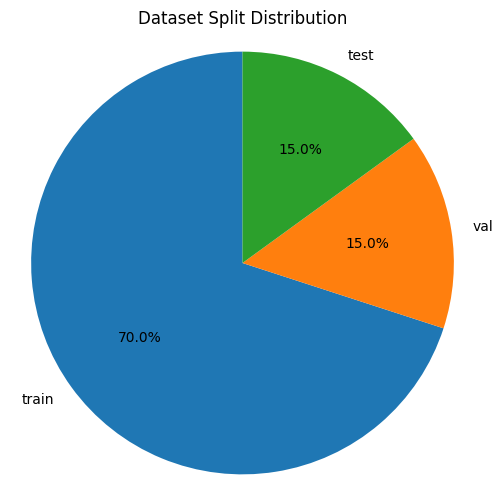

In [ ]:
 #Training, Validation and Testing

#Splitting the datset into the appropraite sections
data_root = "brats-path-2025"
splits = ['train', 'val', 'test']
split_counts = {}

for split in splits:
    count = 0
    split_path = os.path.join(data_root, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            count += len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    split_counts[split] = count

# Pie Chart
plt.figure(figsize=(6,6))
plt.pie(split_counts.values(), labels=split_counts.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Dataset Split Distribution')
plt.axis('equal')
plt.show()


In [ ]:
#Data Preparation and Model Preperation

# Transformation - resizing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Grouping the images into training validation and test sections
train_dataset = datasets.ImageFolder(os.path.join(data_root, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_root, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_root, 'test'), transform=transform)

# Batch size = 32 , small batch used for training.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['CT', 'DM', 'IC', 'LI', 'MP', 'NC', 'PL', 'PN', 'WM']


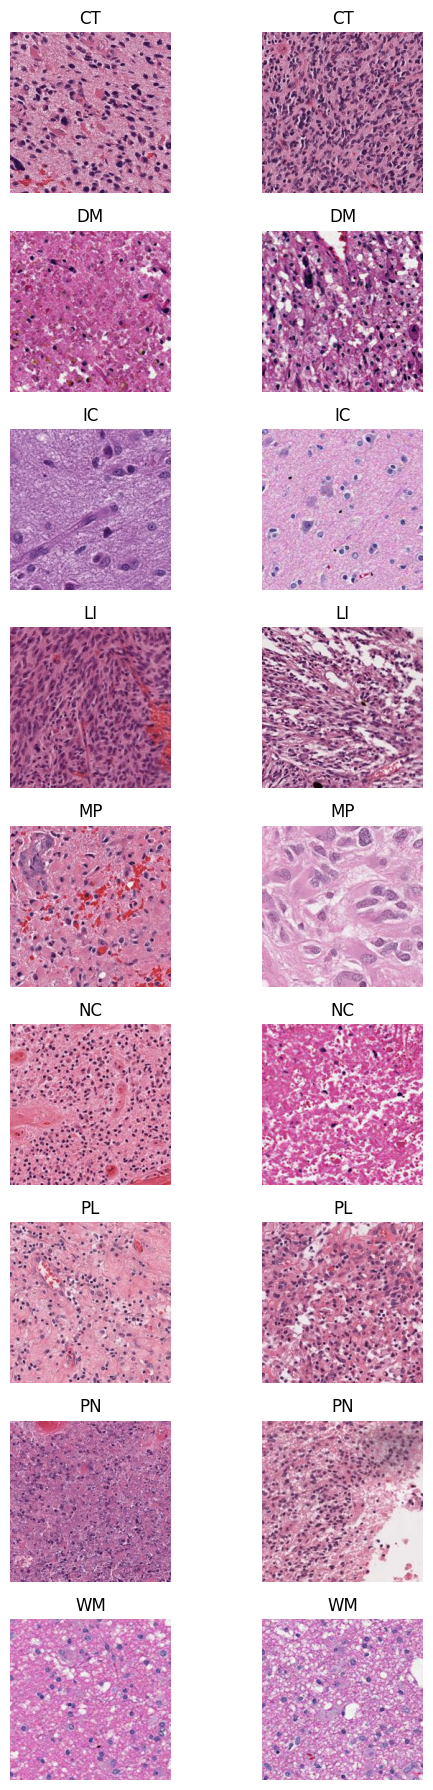

In [ ]:
# Visualising what the patches look like in each tumour type (classes)

images_per_class = {cls: [] for cls in range(len(class_names))}

for images, labels in train_loader:
    for img, label in zip(images, labels):
        if len(images_per_class[label.item()]) < 2:
            images_per_class[label.item()].append(img)
    if all(len(v) == 2 for v in images_per_class.values()):
        break

fig, axes = plt.subplots(len(class_names), 2, figsize=(6, 18))
for class_idx, imgs in images_per_class.items():
    for i in range(2):
        ax = axes[class_idx, i]
        ax.imshow(np.transpose(imgs[i].numpy(), (1, 2, 0)))
        ax.set_title(class_names[class_idx])
        ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
#MobileNetV2 - Model set up


# Loading MobileNetV2 with pretrained weights (ImageNet)
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)

# Base layers stopped from updating in training
for param in model.parameters():
    param.requires_grad = False

# Last layer should output the classes
model.classifier[1] = nn.Linear(model.last_channel, len(class_names))
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 108MB/s] 


In [ ]:
# Adapting MobileNetV2 - learning and stopping

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Early stopping to reduce wasting time if the model is not improving
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
#Training MobileNetV2

num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

early_stopper = EarlyStopping(patience=5)

for epoch in range(15):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    num_batches = len(train_loader)

    print(f"Epoch: {epoch + 1} | ", end="", flush=True)

    progress_shown = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Progress bar to see if working
        percentage_complete = (batch_idx + 1) / num_batches
        bar_ticks = int(percentage_complete * 100)
        while progress_shown < bar_ticks:
            print("-", end="", flush=True)
            progress_shown += 1

    print(f" ({progress_shown})")

    train_acc = correct / total
    train_losses.append(train_loss / num_batches)
    train_accuracies.append(train_acc)

    # Checking performance through validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    # Metrics after epoch
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}\n")

    scheduler.step()
    early_stopper(val_losses[-1])
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break


Epoch: 1 | ---------------------------------------------------------------------------------------------------- (100)
Train Loss: 0.4949, Train Acc: 0.8386, Val Loss: 0.3399, Val Acc: 0.8895

Epoch: 2 | ---------------------------------------------------------------------------------------------------- (100)
Train Loss: 0.4464, Train Acc: 0.8509, Val Loss: 0.3510, Val Acc: 0.8867

Epoch: 3 | ---------------------------------------------------------------------------------------------------- (100)
Train Loss: 0.4431, Train Acc: 0.8521, Val Loss: 0.3191, Val Acc: 0.8948

Epoch: 4 | ---------------------------------------------------------------------------------------------------- (100)
Train Loss: 0.4401, Train Acc: 0.8520, Val Loss: 0.3095, Val Acc: 0.8975

Epoch: 5 | ---------------------------------------------------------------------------------------------------- (100)
Train Loss: 0.4407, Train Acc: 0.8517, Val Loss: 0.3140, Val Acc: 0.8966

Epoch: 6 | -----------------------------

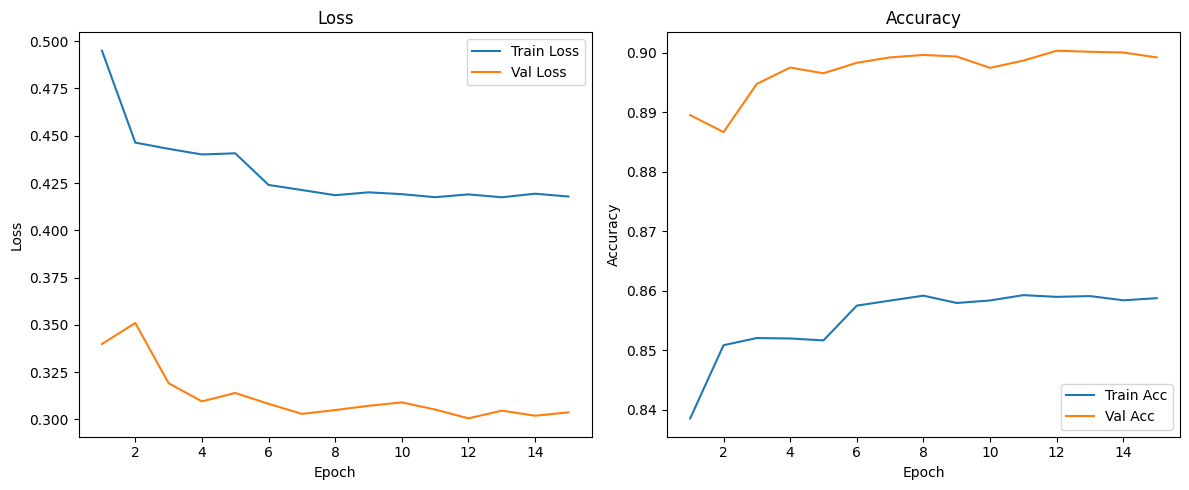

In [ ]:
# Training vs Validation Graphs

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Testing on unseen data

model.eval()
all_preds = []
all_labels = []

num_batches = len(test_loader)
progress_shown = 0
print("Evaluating on Test Set | ", end="", flush=True)

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

          # Checking performance on testing data as it's generating
        percentage_complete = (batch_idx + 1) / num_batches
        bar_ticks = int(percentage_complete * 100)
        while progress_shown < bar_ticks:
            print("-", end="", flush=True)
            progress_shown += 1

print(f" ({progress_shown})")

# Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")


Evaluating on Test Set | ---------------------------------------------------------------------------------------------------- (100)

Test Accuracy: 0.8979
Precision: 0.8492
Recall: 0.7508
F1 Score: 0.7889


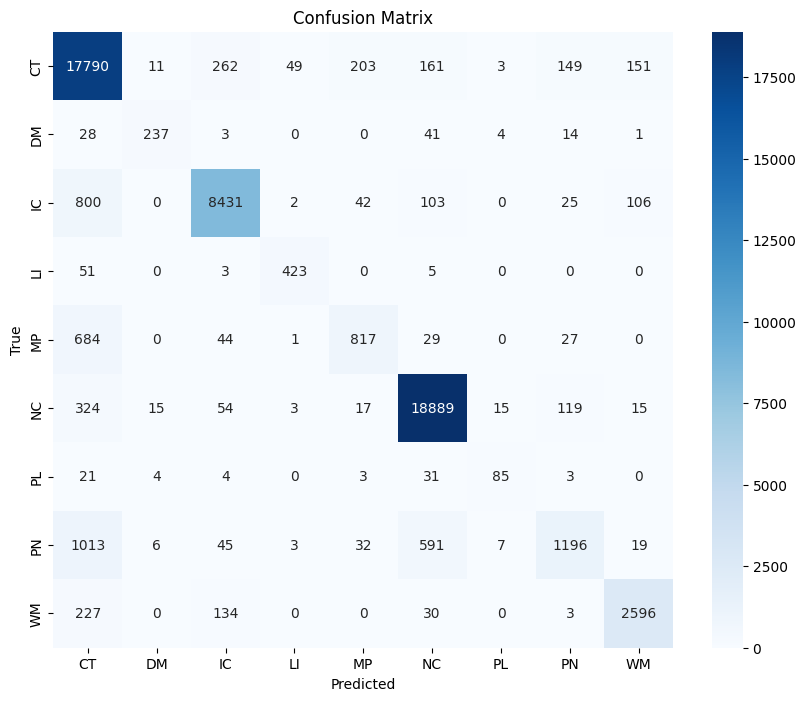

In [ ]:
#Confusion Matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


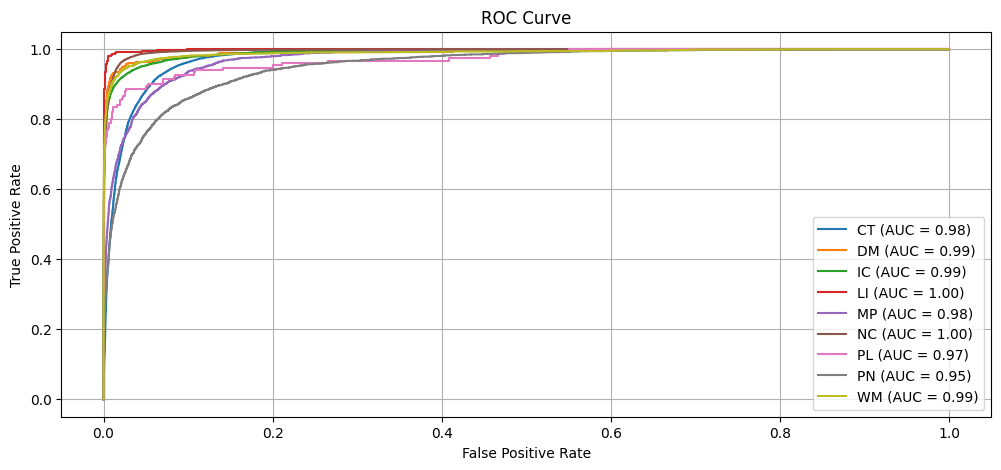

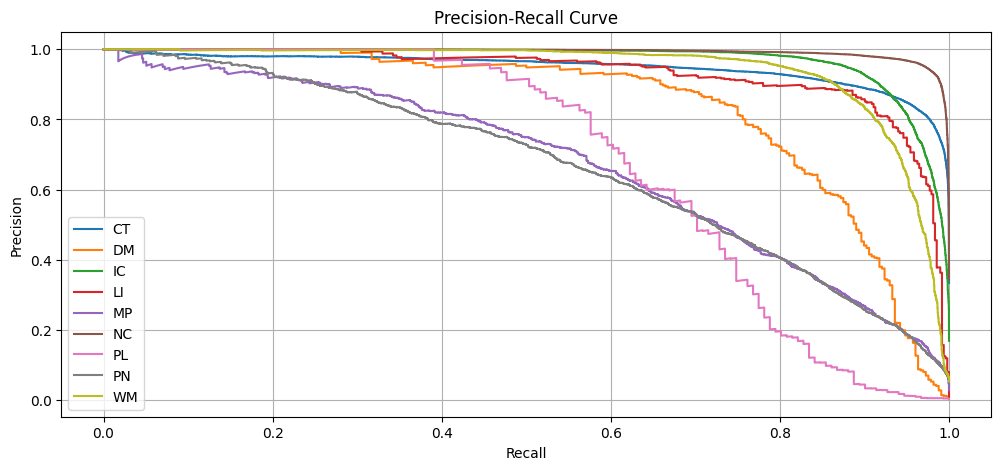

In [ ]:
#Plotting all my metrics


# Encoding the labels
y_test_bin = label_binarize(all_labels, classes=range(len(class_names)))

# Probbabilities predictions
all_probs = []
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

# ROC AUC
plt.figure(figsize=(12, 5))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_score:.2f})')

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Precision Recall
plt.figure(figsize=(12, 5))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], all_probs[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]}')

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Metrics in a table

# Ensure inputs are numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Prepare storage
class_metrics = {
    "Class": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Calculate per-class metrics
for i, class_name in enumerate(class_names):
    # Binary masks for current class
    true_mask = (all_labels == i)
    pred_mask = (all_preds == i)

    # Accuracy: thhe correct predicted samples
    class_correct = np.sum(true_mask & pred_mask)
    class_total = np.sum(true_mask)
    class_acc = class_correct / class_total if class_total > 0 else 0.0

    # Precision, Recall, F1
    prec = precision_score(true_mask, pred_mask, zero_division=0)
    rec = recall_score(true_mask, pred_mask, zero_division=0)
    f1 = f1_score(true_mask, pred_mask, zero_division=0)

    # Results being stored
    class_metrics["Class"].append(class_name)
    class_metrics["Accuracy"].append(round(class_acc, 4))
    class_metrics["Precision"].append(round(prec, 4))
    class_metrics["Recall"].append(round(rec, 4))
    class_metrics["F1-Score"].append(round(f1, 4))

# Dataframe results
df_class_metrics = pd.DataFrame(class_metrics)
print("Class-wise Performance Metrics:\n")
print(df_class_metrics)


Class-wise Performance Metrics:

  Class  Accuracy  Precision  Recall  F1-Score
0    CT    0.9473     0.8497  0.9473    0.8958
1    DM    0.7226     0.8681  0.7226    0.7887
2    IC    0.8866     0.9389  0.8866    0.9120
3    LI    0.8776     0.8794  0.8776    0.8785
4    MP    0.5100     0.7334  0.5100    0.6016
5    NC    0.9711     0.9502  0.9711    0.9605
6    PL    0.5629     0.7456  0.5629    0.6415
7    PN    0.4107     0.7786  0.4107    0.5378
8    WM    0.8682     0.8989  0.8682    0.8833


In [ ]:
# Validation predictions

anon_folder = "Validation-Data-anoymized"
image_paths = [os.path.join(anon_folder, fname)
               for fname in os.listdir(anon_folder)
               if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

model.eval()
predictions = []

# Define transform (same as train)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

with torch.no_grad():
    for img_path in tqdm(image_paths):
        image = Image.open(img_path).convert('RGB')
        input_tensor = preprocess(image).unsqueeze(0).to(device)

        output = model(input_tensor)
        prob = torch.softmax(output, dim=1)
        conf_score, predicted_class = torch.max(prob, 1)

        predictions.append({
            "Image-Name": os.path.basename(img_path),
            "Predicted Class": class_names[predicted_class.item()],
            "Confidence Score": conf_score.item()
        })

# Dataframe csv for BraTS-path inpiut
val_predictions = pd.DataFrame(predictions)
val_predictions.to_csv("val_predictions.csv", index=False)
print("Saved as val_predictions.csv")

# Resulyts
val_predictions.head()


100%|██████████| 294/294 [00:05<00:00, 51.61it/s]

Saved as val_predictions.csv


,Image-Name,Predicted Class,Confidence Score
0,BraTSPath_Val_0000146.png,NC,0.449121
1,BraTSPath_Val_0000080.png,IC,0.460153
2,BraTSPath_Val_0000087.png,IC,0.487777
3,BraTSPath_Val_0000025.png,CT,0.635587
4,BraTSPath_Val_0000149.png,CT,0.463465
